In [2]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Recidivism Prediction Preprocessing") \
    .getOrCreate()


In [3]:
# Read the dataset
df = spark.read.csv('NIJ.csv', header=True, inferSchema=True)


In [4]:
df.head()

Row(ID=1, Gender='M', Race='BLACK', Age_at_Release='43-47', Residence_PUMA=16, Gang_Affiliated=False, Supervision_Risk_Score_First=3, Supervision_Level_First='Standard', Education_Level='At least some college', Dependents='3 or more', Prison_Offense='Drug', Prison_Years='More than 3 years', Prior_Arrest_Episodes_Felony='6', Prior_Arrest_Episodes_Misd='6 or more', Prior_Arrest_Episodes_Violent='1', Prior_Arrest_Episodes_Property='3', Prior_Arrest_Episodes_Drug='3', Prior_Arrest_Episodes_PPViolationCharges='4', Prior_Arrest_Episodes_DVCharges=False, Prior_Arrest_Episodes_GunCharges=False, Prior_Conviction_Episodes_Felony='3 or more', Prior_Conviction_Episodes_Misd='3', Prior_Conviction_Episodes_Viol=False, Prior_Conviction_Episodes_Prop='2', Prior_Conviction_Episodes_Drug='2 or more', Prior_Conviction_Episodes_PPViolationCharges=False, Prior_Conviction_Episodes_DomesticViolenceCharges=False, Prior_Conviction_Episodes_GunCharges=False, Prior_Revocations_Parole=False, Prior_Revocations_Pro

In [5]:
from pyspark.sql.functions import col, count, when

# Define the columns to check for null values
columns = [
    'Age_at_Release', 'Gender', 'Prior_Conviction_Episodes_Felony', 'Education_Level',
    'Supervision_Risk_Score_First', 'Prior_Arrest_Episodes_Violent',
    'DrugTests_THC_Positive', 'Percent_Days_Employed', 'Recidivism_Within_3years'
]

# Counting nulls for each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in columns])

# Show the null counts for each column
null_counts.show()

# Drop rows that have any null values in the specified columns
df_nonulls = df.dropna(how='any', subset=columns)

# Show the result to confirm rows are dropped
df_nonulls.show()


+--------------+------+--------------------------------+---------------+----------------------------+-----------------------------+----------------------+---------------------+------------------------+
|Age_at_Release|Gender|Prior_Conviction_Episodes_Felony|Education_Level|Supervision_Risk_Score_First|Prior_Arrest_Episodes_Violent|DrugTests_THC_Positive|Percent_Days_Employed|Recidivism_Within_3years|
+--------------+------+--------------------------------+---------------+----------------------------+-----------------------------+----------------------+---------------------+------------------------+
|             0|     0|                               0|              0|                         475|                            0|                  5172|                  462|                       0|
+--------------+------+--------------------------------+---------------+----------------------------+-----------------------------+----------------------+---------------------+----------------

In [6]:
# Count the number of rows remaining
print(f"Number of rows after dropping nulls: {df_nonulls.count()}")


Number of rows after dropping nulls: 19952


In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Categorical columns to index and encode
categoricalColumns = ['Age_at_Release', 'Gender', 'Education_Level','Race']

# Create indexers for the categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid='keep') for column in categoricalColumns]

# Create encoders for the indexed columns
encoders = [OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[indexer.getOutputCol() + "_ohe"]) for indexer in indexers]

# Combine indexers and encoders in a pipeline
pipeline = Pipeline(stages=indexers + encoders)

# Fit the pipeline to the data
df_encoded = pipeline.fit(df_nonulls).transform(df_nonulls)

# Show the encoded DataFrame
df_encoded.show(5)




+---+------+-----+--------------+--------------+---------------+----------------------------+-----------------------+--------------------+----------+---------------+-----------------+----------------------------+--------------------------+-----------------------------+------------------------------+--------------------------+----------------------------------------+-------------------------------+--------------------------------+--------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+--------------------------------------------+-------------------------------------------------+------------------------------------+------------------------+---------------------------+---------------+----------------+---------------+-------------------------------+----------------------+-----------------------+--------------------------------+-------------------+-------------------+------------------------

In [8]:
from pyspark.sql.functions import when, col

# List of columns to apply conversion logic
columns_to_convert = [
    "Prior_Arrest_Episodes_Felony", "Dependents", "Prior_Arrest_Episodes_Violent",
    "Prior_Arrest_Episodes_Property", "Prior_Arrest_Episodes_Drug",
    "Prior_Arrest_Episodes_PPViolationCharges", "Prior_Conviction_Episodes_Prop",
    "Prior_Conviction_Episodes_Drug", "Prior_Conviction_Episodes_Misd",
    "Prior_Arrest_Episodes_Misd", "Prior_Conviction_Episodes_Felony",
    "Delinquency_Reports", "Prior_Arrest_Episodes_DVCharges",
    "Prior_Arrest_Episodes_GunCharges", "Prior_Conviction_Episodes_Viol"
]

# Apply transformation using reduce-style chaining
for col_name in columns_to_convert:
    df_encoded = df_encoded.withColumn(
        col_name,
        when(col(col_name).rlike(r"(\d+) or more"),
             col(col_name).cast("string").substr(0, 1).cast("int") + 0.5
        ).otherwise(col(col_name).cast("float"))
    )

df_num = df_encoded
df_num.show(5)


+---+------+-----+--------------+--------------+---------------+----------------------------+-----------------------+--------------------+----------+---------------+-----------------+----------------------------+--------------------------+-----------------------------+------------------------------+--------------------------+----------------------------------------+-------------------------------+--------------------------------+--------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+--------------------------------------------+-------------------------------------------------+------------------------------------+------------------------+---------------------------+---------------+----------------+---------------+-------------------------------+----------------------+-----------------------+--------------------------------+-------------------+-------------------+------------------------

In [9]:
columns_to_drop = [ "Age_at_Release_index_ohe","Prior_Conviction_Episodes_GunCharges","Gender_index_ohe", "Education_Level_index_ohe",'Training_Sample',"DrugTests_Other_Positive","Residence_PUMA","Dependents","Prior_Arrest_Episodes_Misd","Prior_Arrest_Episodes_PPViolationCharges","Prior_Conviction_Episodes_Misd","Prior_Conviction_Episodes_PPViolationCharges","Prior_Conviction_Episodes_DomesticViolenceCharge","Prior_Revocations_Parole","Prior_Revocations_Probation","Condition_Other","Avg_Days_per_DrugTest","Residence_Changes","Recidivism_Arrest_Year1","Recidivism_Arrest_Year2","Recidivism_Arrest_Year3","Employment_Exempt","Condition_MH_SA","Condition_Cog_Ed","Violations_ElectronicMonitoring","Jobs_Per_Year","Prior_Conviction_Episodes_DomesticViolenceCharges","Violations_Instruction","Violations_FailToReport","Violations_MoveWithoutPermission"]

df_clean = df_num.drop(*columns_to_drop)
df_clean.show(5)



+---+------+-----+--------------+---------------+----------------------------+-----------------------+--------------------+---------------+-----------------+----------------------------+-----------------------------+------------------------------+--------------------------+-------------------------------+--------------------------------+--------------------------------+------------------------------+------------------------------+------------------------------+-------------------+-------------------+-------------------------+----------------------+--------------------------+-----------------------+---------------------+------------------------+--------------------+------------+---------------------+----------+--------------+
| ID|Gender| Race|Age_at_Release|Gang_Affiliated|Supervision_Risk_Score_First|Supervision_Level_First|     Education_Level| Prison_Offense|     Prison_Years|Prior_Arrest_Episodes_Felony|Prior_Arrest_Episodes_Violent|Prior_Arrest_Episodes_Property|Prior_Arrest_Episo

In [10]:
df_clean.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Age_at_Release: string (nullable = true)
 |-- Gang_Affiliated: boolean (nullable = true)
 |-- Supervision_Risk_Score_First: integer (nullable = true)
 |-- Supervision_Level_First: string (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Prison_Offense: string (nullable = true)
 |-- Prison_Years: string (nullable = true)
 |-- Prior_Arrest_Episodes_Felony: double (nullable = true)
 |-- Prior_Arrest_Episodes_Violent: double (nullable = true)
 |-- Prior_Arrest_Episodes_Property: double (nullable = true)
 |-- Prior_Arrest_Episodes_Drug: double (nullable = true)
 |-- Prior_Arrest_Episodes_DVCharges: double (nullable = true)
 |-- Prior_Arrest_Episodes_GunCharges: double (nullable = true)
 |-- Prior_Conviction_Episodes_Felony: double (nullable = true)
 |-- Prior_Conviction_Episodes_Viol: double (nullable = true)
 |-- Prior_Conviction_Episodes_Prop: double (

In [11]:
# Replace boolean values with integers for each column individually

df_eda = df_clean.withColumn("Gang_Affiliated", col("Gang_Affiliated").cast("int"))
# Show the updated DataFrame
df_eda.show()



+---+------+-----+--------------+---------------+----------------------------+-----------------------+--------------------+---------------+--------------------+----------------------------+-----------------------------+------------------------------+--------------------------+-------------------------------+--------------------------------+--------------------------------+------------------------------+------------------------------+------------------------------+-------------------+-------------------+-------------------------+----------------------+--------------------------+-----------------------+---------------------+------------------------+--------------------+------------+---------------------+----------+--------------+
| ID|Gender| Race|Age_at_Release|Gang_Affiliated|Supervision_Risk_Score_First|Supervision_Level_First|     Education_Level| Prison_Offense|        Prison_Years|Prior_Arrest_Episodes_Felony|Prior_Arrest_Episodes_Violent|Prior_Arrest_Episodes_Property|Prior_Arrest

In [12]:
df_eda.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Age_at_Release: string (nullable = true)
 |-- Gang_Affiliated: integer (nullable = true)
 |-- Supervision_Risk_Score_First: integer (nullable = true)
 |-- Supervision_Level_First: string (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Prison_Offense: string (nullable = true)
 |-- Prison_Years: string (nullable = true)
 |-- Prior_Arrest_Episodes_Felony: double (nullable = true)
 |-- Prior_Arrest_Episodes_Violent: double (nullable = true)
 |-- Prior_Arrest_Episodes_Property: double (nullable = true)
 |-- Prior_Arrest_Episodes_Drug: double (nullable = true)
 |-- Prior_Arrest_Episodes_DVCharges: double (nullable = true)
 |-- Prior_Arrest_Episodes_GunCharges: double (nullable = true)
 |-- Prior_Conviction_Episodes_Felony: double (nullable = true)
 |-- Prior_Conviction_Episodes_Viol: double (nullable = true)
 |-- Prior_Conviction_Episodes_Prop: double (

In [13]:
df_eda = df_eda.withColumn("Prior_Conviction_Episodes_Viol", col("Prior_Conviction_Episodes_Viol").cast("int"))
df_eda = df_eda.withColumn("Recidivism_Within_3years", col("Recidivism_Within_3years").cast("int"))

df_eda.show(5)

+---+------+-----+--------------+---------------+----------------------------+-----------------------+--------------------+---------------+-----------------+----------------------------+-----------------------------+------------------------------+--------------------------+-------------------------------+--------------------------------+--------------------------------+------------------------------+------------------------------+------------------------------+-------------------+-------------------+-------------------------+----------------------+--------------------------+-----------------------+---------------------+------------------------+--------------------+------------+---------------------+----------+--------------+
| ID|Gender| Race|Age_at_Release|Gang_Affiliated|Supervision_Risk_Score_First|Supervision_Level_First|     Education_Level| Prison_Offense|     Prison_Years|Prior_Arrest_Episodes_Felony|Prior_Arrest_Episodes_Violent|Prior_Arrest_Episodes_Property|Prior_Arrest_Episo

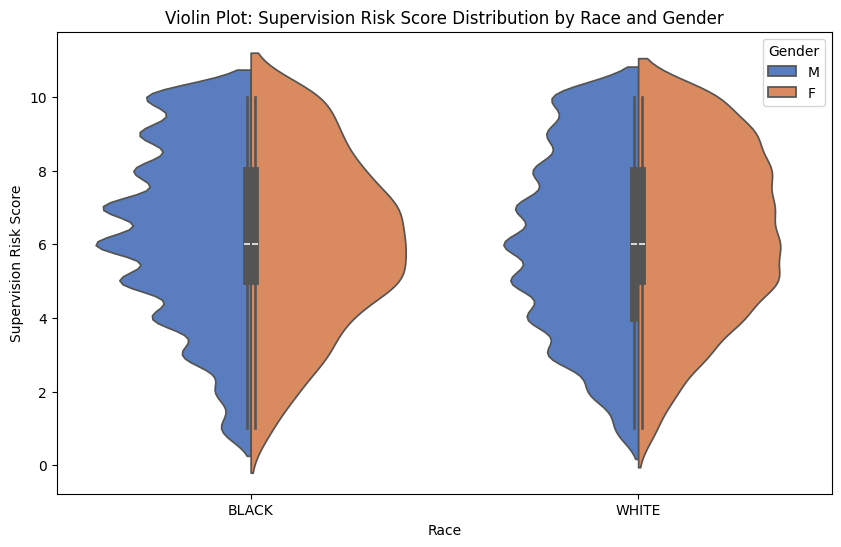

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_eda.toPandas()

# Create the violin plot using Seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_pandas,  # Use the pandas DataFrame
    x="Race",
    y="Supervision_Risk_Score_First",
    hue="Gender",
    split=True,
    palette="muted"
)
plt.title("Violin Plot: Supervision Risk Score Distribution by Race and Gender")
plt.xlabel("Race")
plt.ylabel("Supervision Risk Score")
plt.show()





In [15]:
df_pandas.head()

,ID,Gender,Race,Age_at_Release,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Prison_Offense,Prison_Years,...,DrugTests_THC_Positive,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,Percent_Days_Employed,Recidivism_Within_3years,Age_at_Release_index,Gender_index,Education_Level_index,Race_index,Race_index_ohe
0,1,M,BLACK,43-47,0.0,3,Standard,At least some college,Drug,More than 3 years,...,0.000000,0.0,0.000000,0.488562,0,5.0,0.0,2.0,0.0,"(1.0, 0.0)"
1,2,M,BLACK,33-37,0.0,6,Specialized,Less than HS diploma,Violent/Non-Sex,More than 3 years,...,0.000000,0.0,0.000000,0.425234,1,2.0,0.0,1.0,0.0,"(1.0, 0.0)"
2,3,M,BLACK,48 or older,0.0,7,High,At least some college,Drug,1-2 years,...,0.333333,0.0,0.166667,0.000000,1,3.0,0.0,2.0,0.0,"(1.0, 0.0)"
3,4,M,WHITE,38-42,0.0,7,High,Less than HS diploma,Property,1-2 years,...,0.000000,0.0,0.000000,1.000000,0,4.0,0.0,1.0,1.0,"(0.0, 1.0)"
4,5,M,WHITE,33-37,0.0,4,Specialized,Less than HS diploma,Violent/Non-Sex,1-2 years,...,0.000000,0.0,0.058824,0.203562,1,2.0,0.0,1.0,1.0,"(0.0, 1.0)"


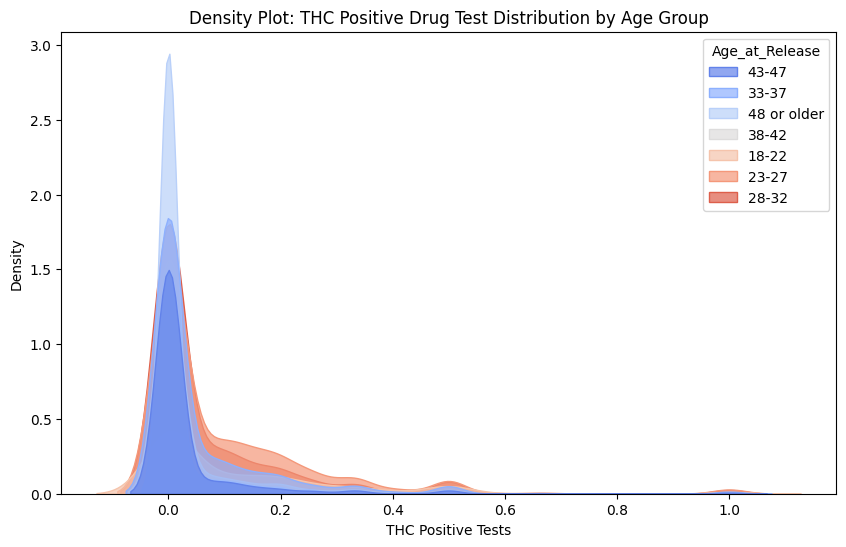

In [16]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_pandas,
    x="DrugTests_THC_Positive",
    hue="Age_at_Release",
    fill=True,
    palette="coolwarm",
    alpha=0.7
)
plt.title("Density Plot: THC Positive Drug Test Distribution by Age Group")
plt.xlabel("THC Positive Tests")
plt.ylabel("Density")
plt.show()



/tmp/ipython-input-17-4125707982.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pandas, x='Gender', palette='coolwarm', edgecolor='black')


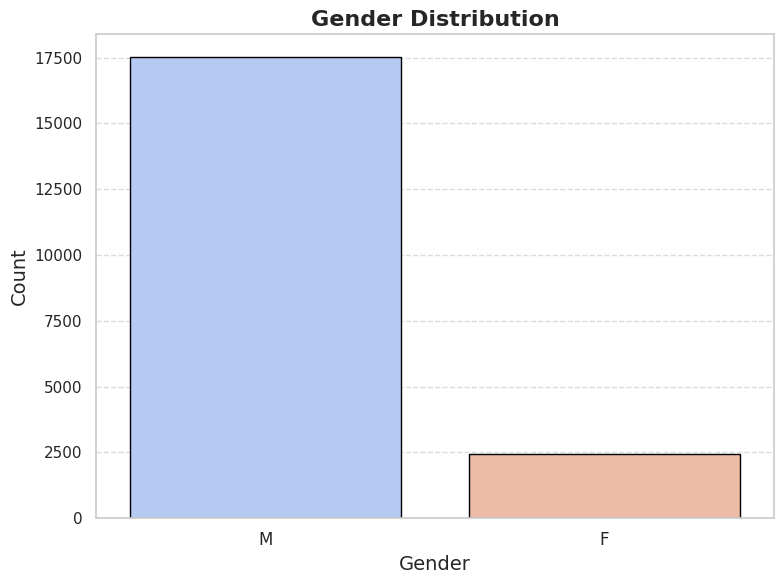

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a style for better aesthetics
sns.set(style="whitegrid")

# Create the countplot with a better color palette
plt.figure(figsize=(8, 6))
sns.countplot(data=df_pandas, x='Gender', palette='coolwarm', edgecolor='black')

# Add titles and labels with enhanced font styles
plt.title('Gender Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability (if needed)
plt.xticks(fontsize=12, rotation=0)

# Add a grid for readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()





<Figure size 1200x800 with 0 Axes>

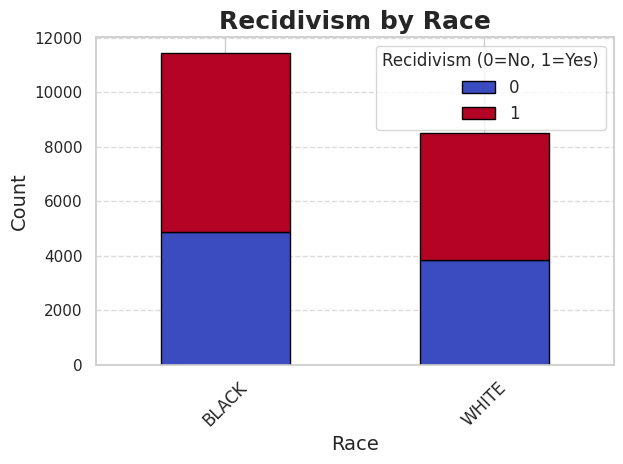

In [18]:


import pandas as pd
import matplotlib.pyplot as plt

# Cross-tabulation
cross_tab = pd.crosstab(df_pandas['Race'], df_pandas['Recidivism_Within_3years'])

# Create a stacked bar plot with custom aesthetics
plt.figure(figsize=(12, 8))
cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm', edgecolor='black')

# Add titles and labels with enhanced font styles
plt.title('Recidivism by Race', fontsize=18, fontweight='bold')
plt.xlabel('Race', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Improve the legend for clarity
plt.legend(title='Recidivism (0=No, 1=Yes)', title_fontsize=12, fontsize=12, loc='upper right')

# Rotate x-axis labels for readability (if needed)
plt.xticks(rotation=45, fontsize=12)

# Add gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ensure everything fits nicely within the figure
plt.tight_layout()

# Display the plot
plt.show()


/tmp/ipython-input-19-3267081845.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x='Recidivism_Within_3years', y='Percent_Days_Employed', palette='Set2')


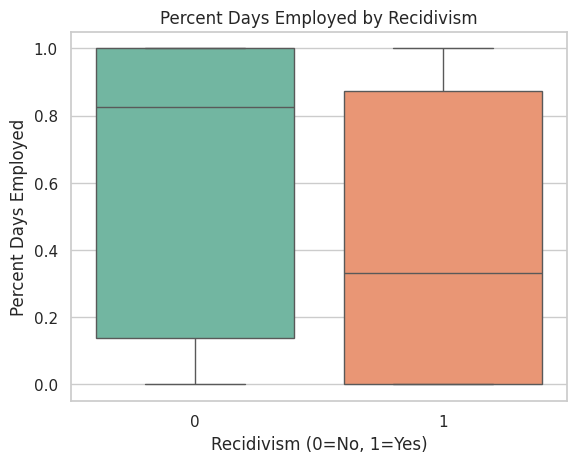

In [19]:
sns.boxplot(data=df_pandas, x='Recidivism_Within_3years', y='Percent_Days_Employed', palette='Set2')
plt.title('Percent Days Employed by Recidivism')
plt.xlabel('Recidivism (0=No, 1=Yes)')
plt.ylabel('Percent Days Employed')
plt.show()


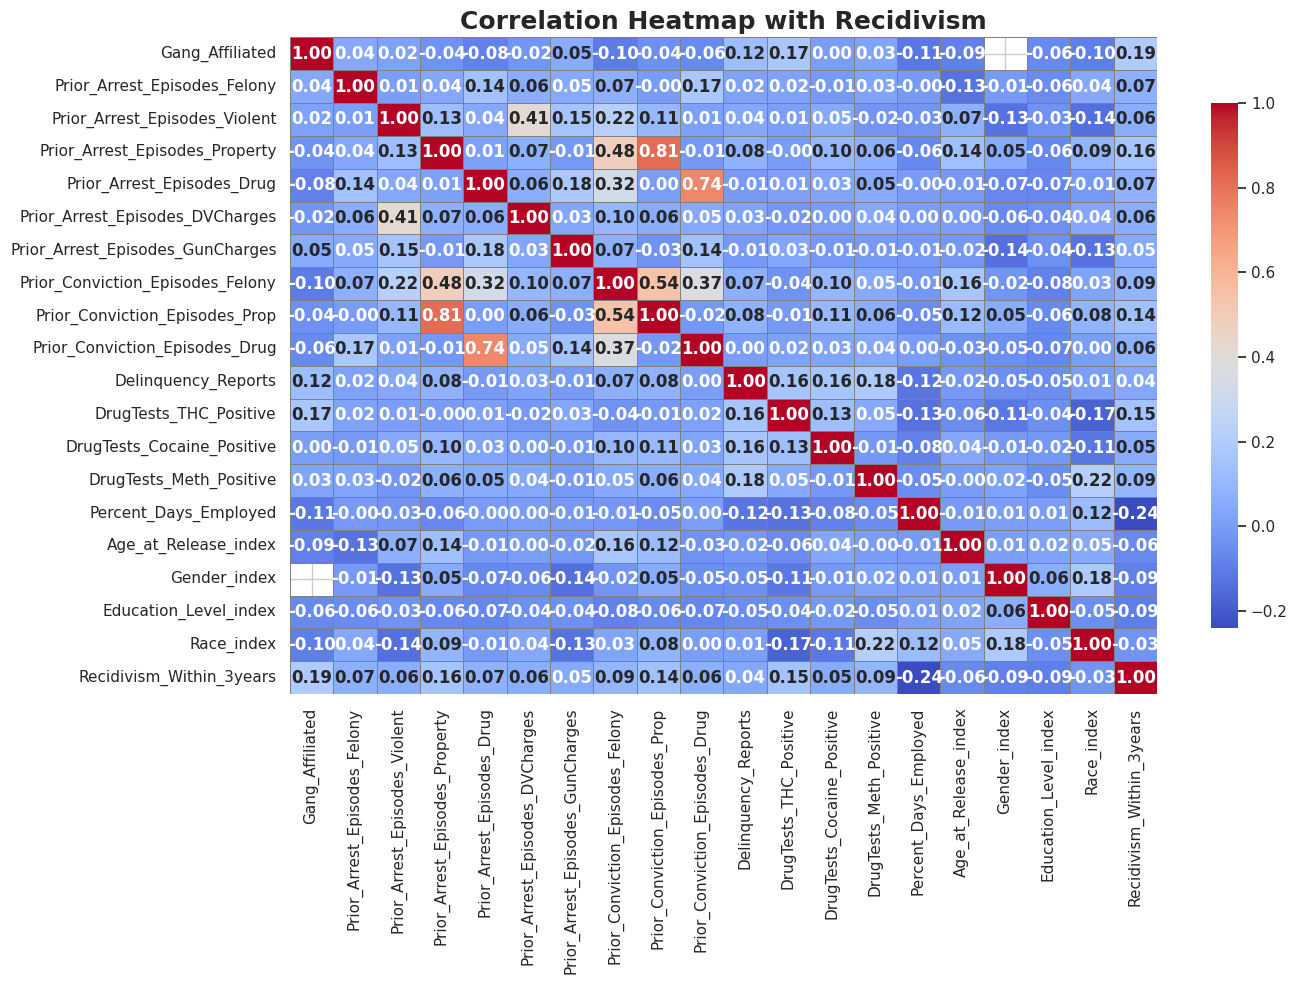

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns and include 'Recidivism_Within_3years'
numerical_cols = df_pandas.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Recidivism_Within_3years' not in numerical_cols:
    numerical_cols.append('Recidivism_Within_3years')

# Calculate correlation matrix
correlation_matrix = df_pandas[numerical_cols].corr()

# Create the heatmap with improved aesthetics
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'shrink': 0.8},
            annot_kws={'size': 12, 'weight': 'bold'}, linewidths=0.5, linecolor='gray')

# Add a title with improved font styling
plt.title('Correlation Heatmap with Recidivism', fontsize=18, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()


In [21]:
from pyspark.sql.functions import col, count, when

# Check for null values in df_eda
null_counts_eda = df_eda.select([count(when(col(c).isNull(), c)).alias(c) for c in df_eda.columns])
null_counts_eda.show()

+---+------+----+--------------+---------------+----------------------------+-----------------------+---------------+--------------+------------+----------------------------+-----------------------------+------------------------------+--------------------------+-------------------------------+--------------------------------+--------------------------------+------------------------------+------------------------------+------------------------------+-------------------+-------------------+-------------------------+----------------------+--------------------------+-----------------------+---------------------+------------------------+--------------------+------------+---------------------+----------+--------------+
| ID|Gender|Race|Age_at_Release|Gang_Affiliated|Supervision_Risk_Score_First|Supervision_Level_First|Education_Level|Prison_Offense|Prison_Years|Prior_Arrest_Episodes_Felony|Prior_Arrest_Episodes_Violent|Prior_Arrest_Episodes_Property|Prior_Arrest_Episodes_Drug|Prior_Arrest_Ep

In [22]:
df_eda.dropna()

DataFrame[ID: int, Gender: string, Race: string, Age_at_Release: string, Gang_Affiliated: int, Supervision_Risk_Score_First: int, Supervision_Level_First: string, Education_Level: string, Prison_Offense: string, Prison_Years: string, Prior_Arrest_Episodes_Felony: double, Prior_Arrest_Episodes_Violent: double, Prior_Arrest_Episodes_Property: double, Prior_Arrest_Episodes_Drug: double, Prior_Arrest_Episodes_DVCharges: double, Prior_Arrest_Episodes_GunCharges: double, Prior_Conviction_Episodes_Felony: double, Prior_Conviction_Episodes_Viol: int, Prior_Conviction_Episodes_Prop: double, Prior_Conviction_Episodes_Drug: double, Delinquency_Reports: double, Program_Attendances: string, Program_UnexcusedAbsences: string, DrugTests_THC_Positive: double, DrugTests_Cocaine_Positive: double, DrugTests_Meth_Positive: double, Percent_Days_Employed: double, Recidivism_Within_3years: int, Age_at_Release_index: double, Gender_index: double, Education_Level_index: double, Race_index: double, Race_index_o

In [23]:
features = [
    'Age_at_Release_index','Gender_index','Race_index','Education_Level_index','DrugTests_THC_Positive','DrugTests_Meth_Positive', 'Supervision_Risk_Score_First', 'Percent_Days_Employed',
     'Prior_Arrest_Episodes_Felony','Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
    'Gang_Affiliated','Prior_Conviction_Episodes_Prop'
]

In [24]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features", handleInvalid="skip")
data = assembler.transform(df_eda)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# Step 4: Split the Data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Step 5: Train the Random Forest Model
rf = RandomForestClassifier(featuresCol="features", labelCol="Recidivism_Within_3years", seed=1234)
rf_model = rf.fit(train_data)

# Step 6: Make Predictions
predictions = rf_model.transform(test_data)

# Step 7: Evaluate the Model
evaluator = BinaryClassificationEvaluator(labelCol="Recidivism_Within_3years", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# Step 8: Hyperparameter Tuning with CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

cross_val = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,  # Use a higher value for better results
    parallelism=2  # Adjust based on available cores
)

cv_model = cross_val.fit(train_data)

# Step 9: Evaluate the Best Model
best_model = cv_model.bestModel
cv_predictions = best_model.transform(test_data)
cv_auc = evaluator.evaluate(cv_predictions)
print(f"Cross-Validated AUC: {cv_auc}")

AUC: 0.7300709607861997


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Step 5: Define Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="Recidivism_Within_3years", maxIter=10)

# Step 6: Define Hyperparameter Grid
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Step 7: Cross-Validator for Logistic Regression
lr_cross_val = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=evaluator,
    numFolds=3,  # 3-fold Cross Validation
    parallelism=2  # Adjust based on available cores
)

# Step 8: Train Logistic Regression with Cross-Validation
lr_cv_model = lr_cross_val.fit(train_data)

# Step 9: Evaluate the Best Logistic Regression Model
lr_best_model = lr_cv_model.bestModel
lr_cv_predictions = lr_best_model.transform(test_data)
lr_cv_auc = evaluator.evaluate(lr_cv_predictions)
print(f"Logistic Regression Cross-Validated AUC: {lr_cv_auc}")


In [ ]:
from pyspark.ml.classification import GBTClassifier

# Step 5: Define GBT Model
gbt = GBTClassifier(featuresCol="features", labelCol="Recidivism_Within_3years", seed=1234)

# Step 6: Define Hyperparameter Grid
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Step 7: Cross-Validator for GBT
gbt_cross_val = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=gbt_param_grid,
    evaluator=evaluator,
    numFolds=3,  # 3-fold Cross Validation
    parallelism=2  # Adjust based on available cores
)

# Step 8: Train GBT with Cross-Validation
gbt_cv_model = gbt_cross_val.fit(train_data)

# Step 9: Evaluate the Best GBT Model
gbt_best_model = gbt_cv_model.bestModel
gbt_cv_predictions = gbt_best_model.transform(test_data)
gbt_cv_auc = evaluator.evaluate(gbt_cv_predictions)
print(f"Gradient-Boosted Trees Cross-Validated AUC: {gbt_cv_auc}")


In [ ]:
pip install sparkxgb


In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Step 1: Define SVM Model (Linear Support Vector Classifier)
svm = LinearSVC(featuresCol="features", labelCol="Recidivism_Within_3years", predictionCol="prediction", maxIter=10, regParam=0.1)

# Step 2: Define Hyperparameter Grid for SVM
svm_param_grid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1]) \
    .addGrid(svm.maxIter, [50, 100]) \
    .build()

# Step 3: Define Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Recidivism_Within_3years", metricName="areaUnderROC")

# Step 4: Cross-Validator for SVM
svm_cross_val = CrossValidator(
    estimator=svm,
    estimatorParamMaps=svm_param_grid,
    evaluator=evaluator,
    numFolds=3,  # 3-fold Cross Validation
    parallelism=2  # Adjust based on available cores
)

# Step 5: Train SVM with Cross-Validation
svm_cv_model = svm_cross_val.fit(train_data)

# Step 6: Evaluate the Best SVM Model
svm_best_model = svm_cv_model.bestModel
svm_cv_predictions = svm_best_model.transform(test_data)
svm_cv_auc = evaluator.evaluate(svm_cv_predictions)
print(f"SVM Cross-Validated AUC: {svm_cv_auc}")
